In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
SHOW_GIFS = True

# History

The fathers of Particle Swarm Optimization technique are considered James Kennedy and Russel Eberhart, who present them in their paper "Particle Swarm Optimization" in 1995 [[1]]([#Bibliography]). Authors take inspiration in nature, concretely in bird flocking and fish schooling and in their simulations already implemented in that time. We can see the behaviours in the videos bellow.

In [2]:
display.YouTubeVideo('0dskCpuxqtI?start=8', 560, 315)

In [3]:
display.YouTubeVideo('Y-5ffl5_7AI?start=90', 560, 315)

If you play watch through the second video, you can see one of the attempt to fully understand how the fish schooling really behaves by tracking each fish. Although not very important to us, I think it's still interesting.

Let's return to the topic. As scientists found out, the behavior of swarms is most of the time based on very simple rules, but executed in distributed manner. For example, when fish in the swarm see food, it will swim toward it. Otherwise, the fish keeps the same direction as its neighboors. As some wish change their direction toward the food, the rest of the swarm would follow them. As a result, the whole swarm reach the food and, in case there is no competetion between individuals (enough food for each one), each fish feed itself. 

Although there is no explicit communication, the simple rules provide simple information sharing ability inside the flock, increasing the total gain of the group as a whole.

The authors of the paper tried some approaches both to optimize given function and to simulate flock most "lifely". I will start simple and improve the idea further. 

# Particles

In [4]:
import numpy as np
import matplotlib.pylab as plt
import cocoex
import functools
import functions as fn
import execution as exe
import plotting as plot
import inspect
import strategies
import utils
from PIL import Image
import os
import functools

First of all, we will have a set of particles scattered over the parameter space. We can for example let them move randomly around.

In [5]:
definition = inspect.getsource(strategies.random_walk)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def random_walk(particles: np.ndarray, *vars, stepsize: float = 0.2) -> np.ndarray:
    particles = particles  + np.random.normal(0, stepsize, particles.shape)
    return np.maximum(-5, np.minimum(5, particles))

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

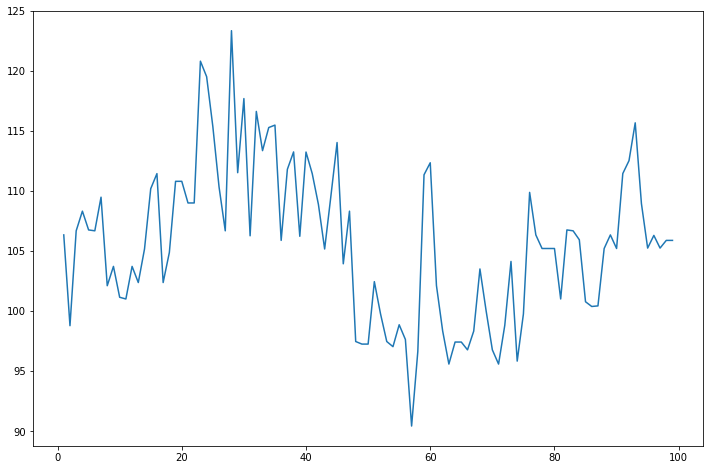

100% (99 of 99) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


38631160

![img](main/001.gif)

In [6]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(function, strategies.random_walk, show_progress=True)
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "001.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/001.gif)")

In Particle Swarm Optimization, the positions are not updated directly, instead, we assign each particle a velocity. Each iteration we modify the velocity and let the velocity determine the next position. Again, we may initialized the velocity uniformly and then update it randomly each iteration. 

Note that the velocity is the main reason, why we call the individuals particles, as velocity is usually connected with something with mass. Otherwise, we could call them just points or dots.

In [7]:
definition = inspect.getsource(strategies.RandomVelocity)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomVelocity:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, *vars, w: float = 1.0, stepsize: float = 0.05):
        self.velocities = w * self.velocities + np.random.normal(0, stepsize, self.velocities.shape)
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomVelocity(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

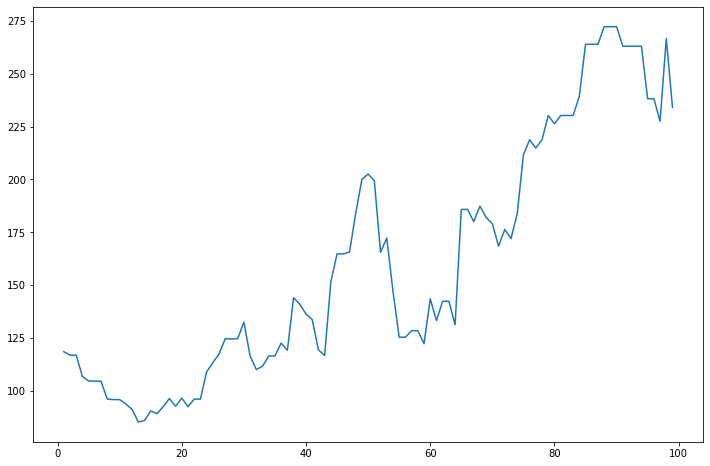

100% (99 of 99) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


38553150

![img](main/002.gif)

In [8]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function, 
            strategies.RandomVelocity.execute, 
            initialization = strategies.RandomVelocity.init,
            show_progress=True)
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "002.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/002.gif)")

Note how the particles end up on the edge. Although I limit the position, so all particles stay within the area, it is not reflect in the in the velocity update. I will deal with it a bit later.

However, what is usually done is to decrease velocity a little bit every iteration, so the velocity can't "explode" too much. The parameter $w$ is there exactly for that purpose. We may set it to value between $(0.0, 1.0)$ to decrease velocity every step. As we will see, proposed constant by the paper is $w = \frac{1}{2 \cdot log(2)} \approx 0.721$.

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

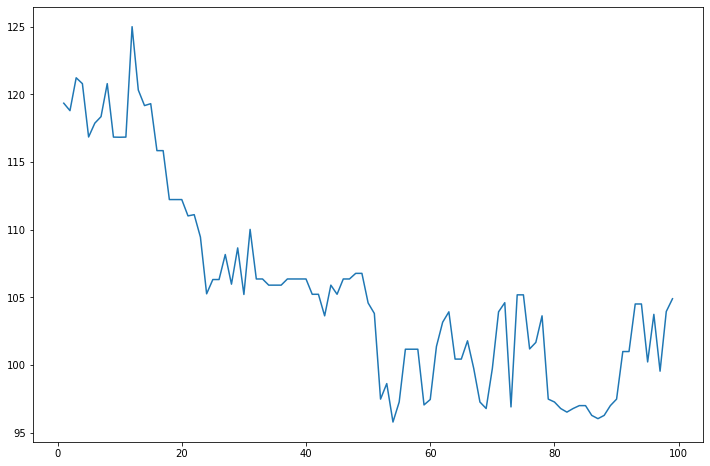

100% (99 of 99) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


38645210

![img](main/003.gif)

In [9]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function, 
            functools.partial(strategies.RandomVelocity.execute, w=1/(2*np.log(2))), 
            initialization = strategies.RandomVelocity.init,
            show_progress=True)
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.show()
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "003.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/003.gif)")

# Comparison - differencial evolution

Previous two examples were great to show the main principes, however, the results were not very satysfying. I wanted some algorithm, that I could compare algorithms with. I choose Differential evolution [[2]](#Bibliography), that was published around the same time (1996) and thus is a good candidate for comparison. Moreover, from my experience, differential evolution works quiet well for continuous optimization.

In the differential evolution, new individuals are based on the following formula.
$$
m_n = \text{Uniform}(p_3, p_0 + F \cdot (p_1 - p_2), CR)
$$

Terms $p_0, \dots, p_3$ are parents. Firstly, the algorithm adds difference of two parents and then performs uniform mutation with probability $1 - CR$. Moreover, I used parental tournament selection to pick up parents for the next iteration.

In [10]:
definition = inspect.getsource(strategies.differential_evolution)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def differential_evolution(population: np.ndarray, fitnesses: np.ndarray, function:cocoex.Problem,
                           parents_fraction: float = 0.6,
                           F: float = 0.8,
                           CR: float = 0.4,
                           ) -> np.ndarray:
    # pickup parents
    num_parents = int(len(population) * parents_fraction)
    parents_tournament_indices = np.random.randint(0, len(population), [2, num_parents])
    comparison = fitnesses[parents_tournament_indices[0]] < fitnesses[parents_tournament_indices[1]]
    better = np.concatenate([
        parents_tournament_indices[0, comparison],
        parents_tournament_indices[1, np.logical_not(comparison)]
    ])
    parents = population[better]

    # create children
    num_children = len(population) - num_parents
    picked_parents = np.random.randint(0, num_parents, [4, num_children])
    crossover_sample = np.random.random([num_children, function.dimension]) > CR
    mutated = parents[picked_parents[0], :] + F * (parents[picked_parents[1]] - parents[picked_parents[2]])
    mutated[crossover_sample] = parents[picked_parents[3]][crossover_sample]
    mutated = np.maximum(-5, np.minimum(5, mutated))

    return np.concatenate([
        parents,
        mutated
    ])

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2D using differential evolution')

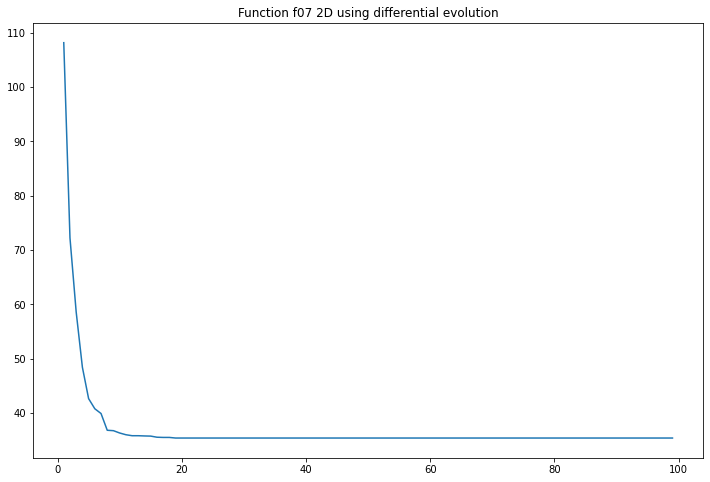

100% (99 of 99) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


5333865

![img](main/004.gif)

Found best solution
Best evaluation: 35.35000000709811


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5D using differential evolution')

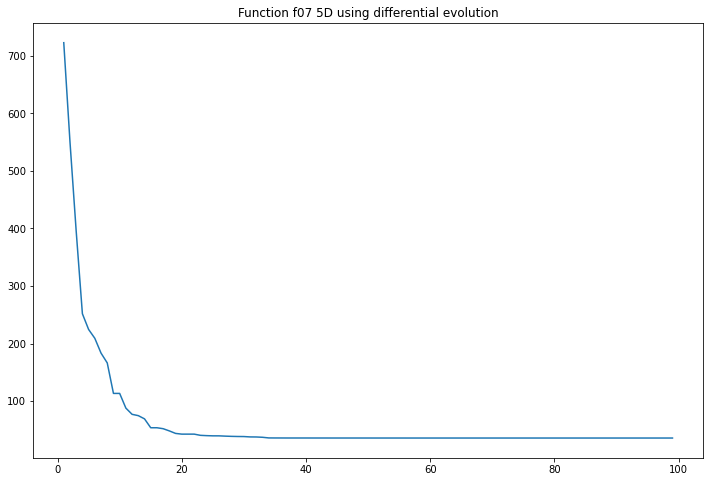

Not found best solution
Best evaluation: 36.01159329447549


In [11]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute(
            function, 
            strategies.differential_evolution, 
            show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_median())
        plt.title(f"Function f07 {function.dimension}D using differential evolution")
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", "004.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/004.gif)")
            

        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

As we can see, the algorithm is already doing something and although it doesn't find the optimal solution (that is $35.35$), it wasn't far away (the BBOB framework accepts solution around $10^{-9}$ of optimum). From now on, I will compare rest of the algorithms to this implementation of differential strategy.

# Taking best particle into account

In order to perform some optimization, we need to guide the particles somehow. The simplest approach is to pick up the best particle and move all other particles toward it. However, the particles shoudn't be fully deterministic. Therefore, I will introduce random weight to this direction, sampled randomly from uniform distribution between $0$ and $c$. Again, $c$ proposed by the paper is $c=0.5 + log(2) \approx 1.193$, so i will stick to this value.

We can thing about the best perticle in a swarm as about some swarm knowledge about the problem.

In [12]:
definition = inspect.getsource(strategies.FollowBest)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class FollowBest:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05):
        best = np.argmin(values)
        best_individual = self.particles[best]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_individual - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return FollowBest(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Found best solution
Best evaluation: 35.35000000008236


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

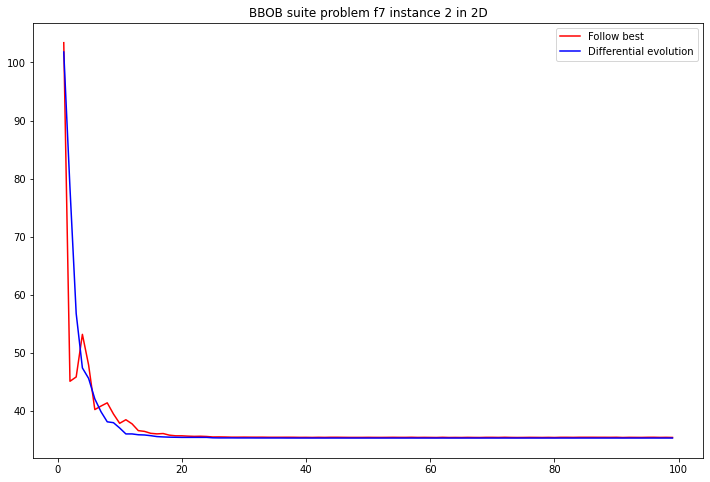

100% (99 of 99) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


18953854

![img](main/005.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Found best solution
Best evaluation: 35.35000000899374


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

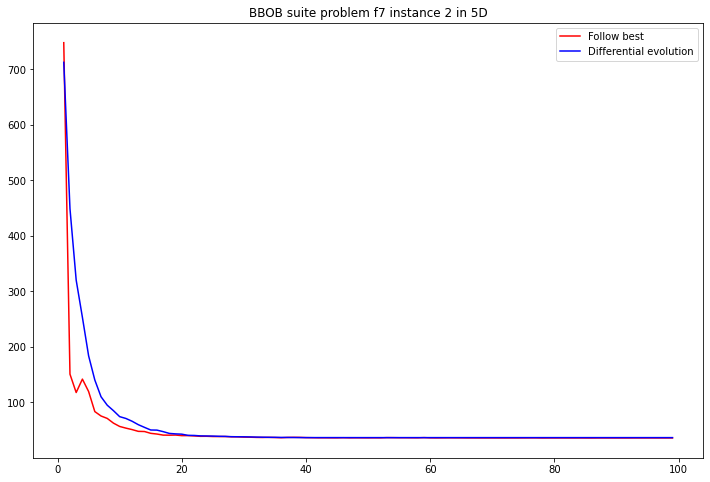

In [13]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function, 
            strategies.FollowBest.execute,
            initialization=strategies.FollowBest.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Follow best", c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plt.legend()
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "005.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/005.gif)")

The approach has one major drawback. Because all the particles are attracted by the best one, they are all moving to the same position. That can easily cause stick in the local optima, as the best particle doesn't  need to be close to the global one. It is easy to demonstrace using function with many local optima - for example `f24`.

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Not found best solution
Best evaluation: 93.54121988909519


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

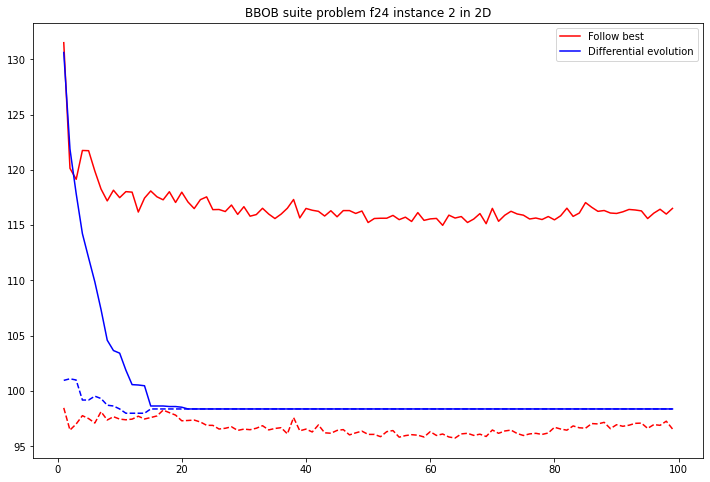

100% (99 of 99) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


35911614

![img](main/006.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 102.34454886186415


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

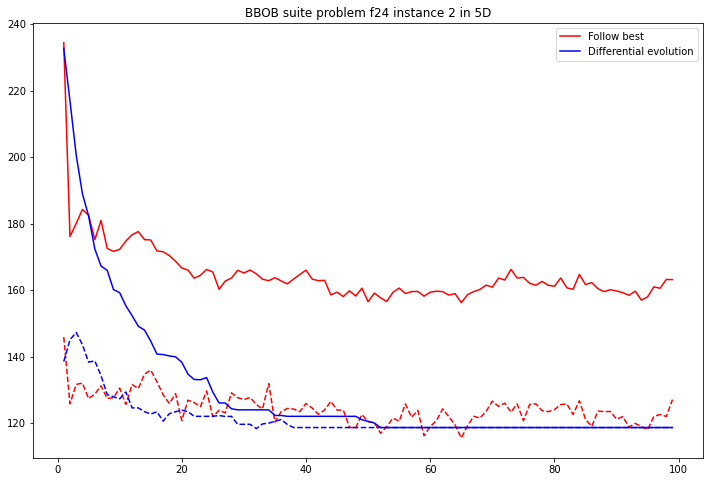

In [14]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[24]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function, 
            strategies.FollowBest.execute,
            initialization=strategies.FollowBest.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Follow best", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "006.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/006.gif)")

Depending on the run, particles get stuck around $\left[2,-2\right]$ or $\left[-4, 4\right]$.In any case, they never converg and are moving around chaotically (that can be caused by the random movement as well). This can be seen from the plots as well, as the differential evolution is in order of magnitude better.

On other hand, this allows particles to evolve over the whole time, compare to the differential evolution, which reached value around $97$ (for `f07`) respectivelly $117$ (for `f24`) and stucked there.

# Neighborhood

This reasoning led to introduce neighborhood. Instead of following best particle from the whole swarm, each particle has some neighbors, with which it compares it's value. The definition of neighborhood (sometimes called topology) is not defined preciselly and there are many approaches.

Firstly, the topology may change after each iteration or may remain static the whole time. In the first approach, each particle will eventually obtain information from all other particles - and thus can compare it's best known value with all the particles. Constant $K$ denotes how many particles inform each iteration and was set t $K=3$ in the paper. Because $K$ is quiet small, the problem is getting stuck in the local optimum is significantly reduced. In the second approach, the particle doesn't know about rest of the search space, unless some of it's neighbor reach it. This prevent swarm to get stuck in the local optima, but reduce amount of information each particle obtain a lot.

Next we need to decide how the topology would look like. First (and deterministic) approach proposed by the paper was called "ring topology". When we index particles, the ring topology for particle $i$ is $\left\{i+1\ mod(N), i+2\ mod(N), \dots, i+K\ mod(N)\right\}$ where $N$ is number of particles. Another proposition was "adaptive random topology", where each particle picks three other particles at random and inform them about it's value (note that this topology in its static version is same as the previous one). Another topology is "von Neumann" topology, that you can see bellow (I will not discuss it here anymore, as it is just modification of the ring topology). Finally, we may simple use $K$ nearest neighboors and inform them (or take information from them).

<a href="https://www.researchgate.net/figure/von-Neumann-neighborhood-structure-for-PSO_fig3_220742792"><img src="https://www.researchgate.net/profile/Enrique_Villa_Diharce/publication/220742792/figure/fig3/AS:472200114380802@1489592688251/von-Neumann-neighborhood-structure-for-PSO.png" alt="von Neumann neighborhood structure for PSO"/></a>

<center>Figure 3: von Neumann neighborhood structure for PSO <a href="#Bibliography">[3]</a></center>

I will show all the topologies and compare them. Let's start with the ring topology.

In [15]:
definition = inspect.getsource(strategies.RingTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RingTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.linspace(list(range(1,1+K)), list(range(N,N+K)), N, dtype=int) % N
        best_neighbor_indices = (np.arange(1,N+1) + np.argmin(values[neighbors], axis=1)) % N
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RingTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Not found best solution
Best evaluation: 35.350000093310605


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

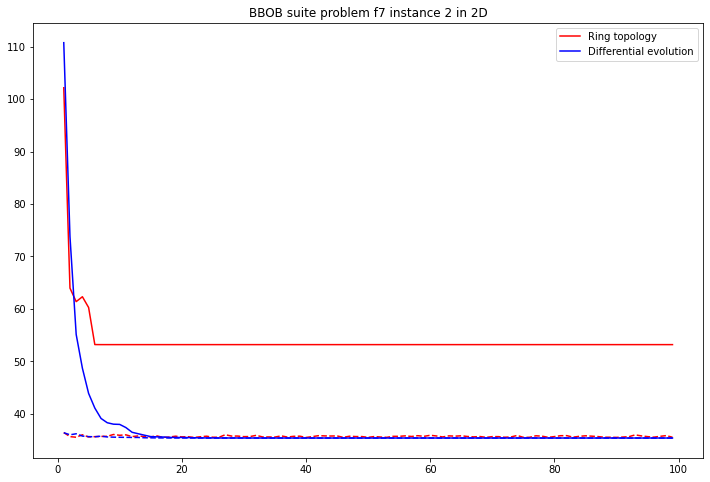

100% (99 of 99) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


38667157

![img](main/007.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 38.71302326425342


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

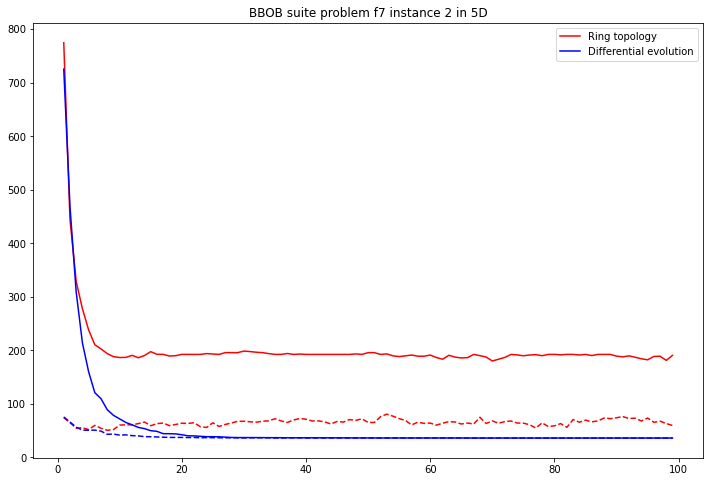

In [16]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function, 
            strategies.RingTopology.execute,
            initialization=strategies.RingTopology.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Ring topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "007.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/007.gif)")

The results are about worse than following the best particle in the swarm. The reason (what I believe) is the information throughput is very small. In order to particle know about better position, some of it's neighbors needs to reach it first - the neighbor can't tell it directly, even if it knows about it. Therefore, behavior is more chaotic and as we can see from the gif, the particles doesn't converge at all.

Now, let's try adaptive random topology.

In [17]:
definition = inspect.getsource(strategies.RandomTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.random.randint(0, N, (N, K))
        best_neighbor_indices = neighbors[range(N), np.argmin(values[neighbors], axis=1)]
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + follow_best + random_walk
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Not found best solution
Best evaluation: 35.35000001497715


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

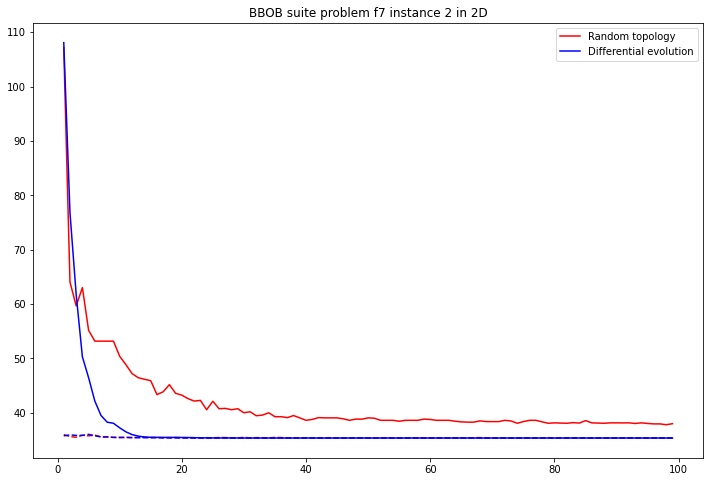

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


3558992

![img](main/008.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution
Best evaluation: 35.66854149471633


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

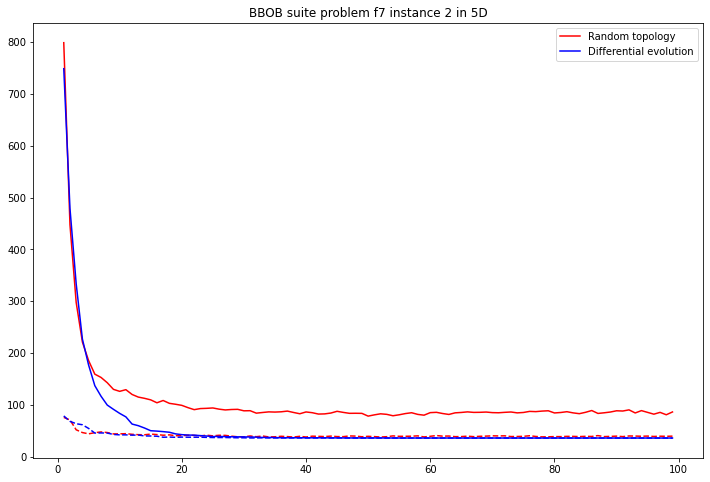

In [18]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function, 
            strategies.RandomTopology.execute,
            initialization=strategies.RandomTopology.init,
            generations=100,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0,::10], show_progress=True)
            with open(os.path.join("main", "008.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/008.gif)")

Using the same constants, the results are much better. There is higher probabilily, that the particle would know about better position much sooner and therefore the swarm created cluster around the global optimum, althought it seems quiet hard to converge there. I believe it is caused by the random steps, as when I removed it, algorithm performed better.

Note that the original reason for random steps was to add some randomness into the process. As we are picking up neigbors randomly this time, we don't need random steps anymore.

Finally, let's look at the nearest topology.

In [19]:
definition = inspect.getsource(strategies.NearestTopology)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class NearestTopology:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(velocity_lowerbound, velocity_upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, values, *vars, w = 1 / (2 * np.log(2)), c = 0.5 + np.log(2), stepsize = 0.05, K=3):
        N = len(self.particles)
        neighbors = np.zeros((N,K), dtype=int)
        for particle_i in range(N):
            distances = np.sqrt(np.sum((self.particles[particle_i][np.newaxis, :] - self.particles) ** 2, axis=1))
            closest = np.argsort(distances)[1:K+1]
            neighbors[particle_i] = closest
        best_neighbor_indices = neighbors[range(N), np.argmin(values[neighbors], axis=1)]
        best_neighbor = self.particles[best_neighbor_indices]
        random_walk = np.random.normal(0, stepsize, self.velocities.shape)
        follow_best = np.random.uniform(0, c, len(self.particles))[:,np.newaxis] * (best_neighbor - self.particles)
        self.velocities = w * self.velocities + random_walk + follow_best
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomTopology(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Found best solution
Best evaluation: 35.35000000111002


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 2D')

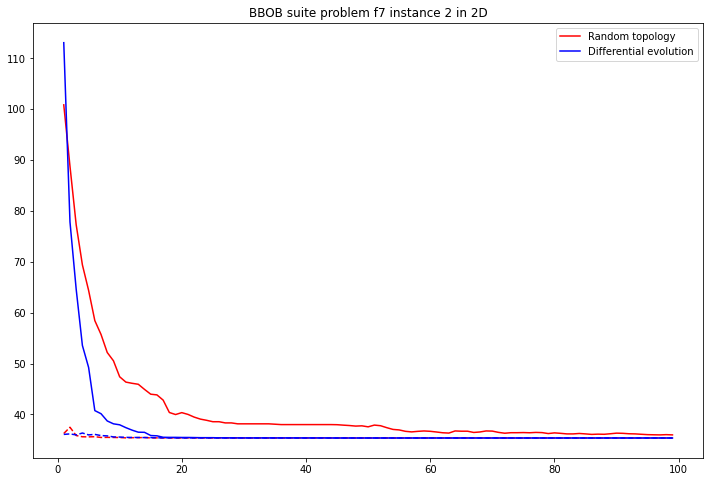

100% (99 of 99) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


27367467

![img](main/009.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Not found best solution
Best evaluation: 35.50170802656232


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f7 instance 2 in 5D')

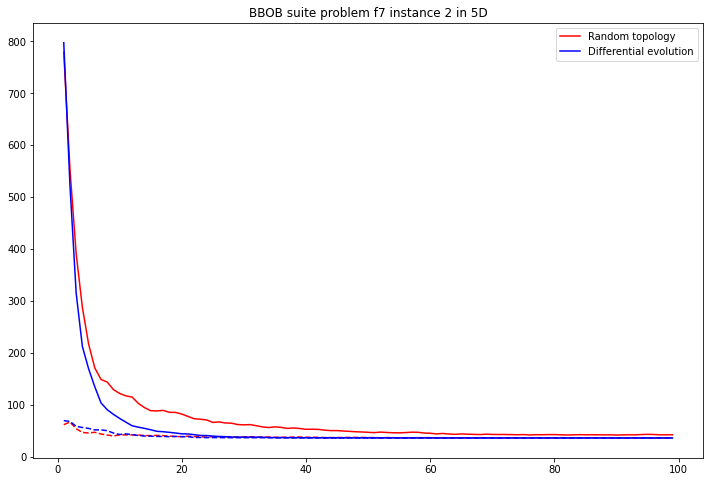

In [20]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute_multiple(
            function, 
            strategies.NearestTopology.execute,
            initialization=strategies.NearestTopology.init,
            show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        eva_population, eva_values = exe.execute_multiple(function,strategies.differential_evolution)

        plt.figure(figsize=(12,8))
        plt.title(function.name)
        plot.plot_aggregated(values, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='r')
        plot.plot_aggregated(values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(eva_values, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(eva_values, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend()
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations[0], show_progress=True)
            with open(os.path.join("main", "009.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/009.gif)")

Although the algorithm seems to perform quiet well, from the movement gif is apparent main disadvantage - particles can create clusters away from the optimum, where they support each other (as they are neighbors). This approach can easily converge to local optima only.

Let's see how would the approaches handles `f24` with many local optima.

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using ring topology
Best evaluation: 93.39080664685736


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using random topology
Best evaluation: 93.3786881583736


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Not found best solution using nearest topology
Best evaluation: 93.42749056101624


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 93.84424035048883


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 2D')

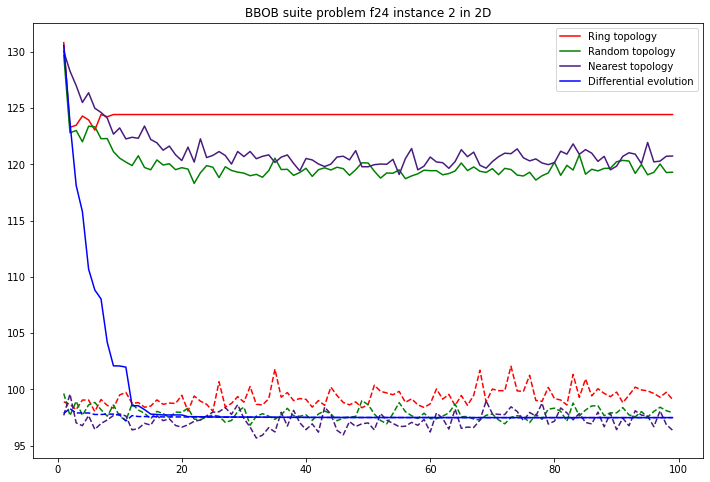

100% (99 of 99) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


38339943

![img](main/010.gif)

100% (99 of 99) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


38398230

![img](main/011.gif)

100% (99 of 99) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


38224572

![img](main/012.gif)

100% (99 of 99) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


6724180

![img](main/013.gif)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using ring topology
Best evaluation: 118.90957019683444


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using random topology
Best evaluation: 110.20477783861648


100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Not found best solution using nearest topology
Best evaluation: 103.19247504282156


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Not found best solution using differential evolution
Best evaluation: 103.28744148917733


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'BBOB suite problem f24 instance 2 in 5D')

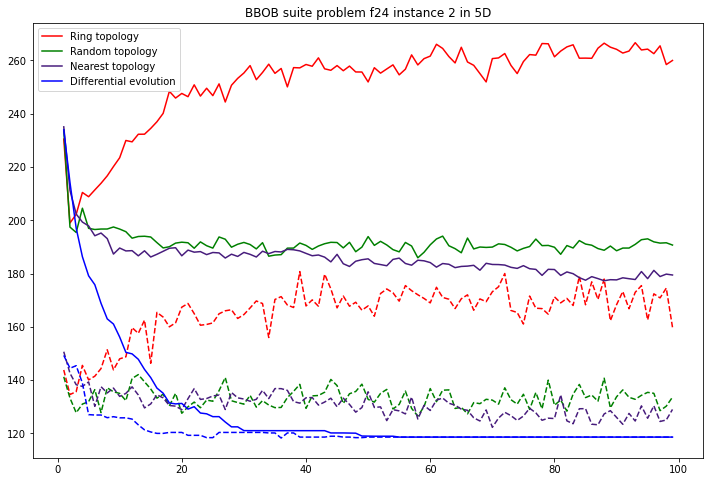

In [23]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[24]) as suite:
    for function_id in suite.ids():  # type: cocoex.Problem
        suite.reset(); function = suite.get_problem(function_id)
        pop_ring, val_ring = exe.execute_multiple(function,strategies.RingTopology.execute,initialization=strategies.RingTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using ring topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_rand, val_rand = exe.execute_multiple(function,strategies.RandomTopology.execute,initialization=strategies.RandomTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using random topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_near, val_near = exe.execute_multiple(function,strategies.NearestTopology.execute,initialization=strategies.NearestTopology.init,show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using nearest topology", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)
        suite.reset(); function = suite.get_problem(function_id)
        pop_eva, val_eva = exe.execute_multiple(function,strategies.differential_evolution, show_progress=True)
        print(('Found' if function.final_target_hit else 'Not found') + " best solution using differential evolution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

        plt.figure(figsize=(12,8));
        plt.title(function.name);
        plot.plot_aggregated(val_ring, plot.popfn_median(), plot.aggfn_median(), label="Ring topology", c='r')
        plot.plot_aggregated(val_ring, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='r')
        plot.plot_aggregated(val_rand, plot.popfn_median(), plot.aggfn_median(), label="Random topology", c='g')
        plot.plot_aggregated(val_rand, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='g')
        plot.plot_aggregated(val_near, plot.popfn_median(), plot.aggfn_median(), label="Nearest topology", c='#471c7c')
        plot.plot_aggregated(val_near, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='#471c7c')
        plot.plot_aggregated(val_eva, plot.popfn_median(), plot.aggfn_median(), label="Differential evolution", c='b')
        plot.plot_aggregated(val_eva, plot.popfn_min(), plot.aggfn_median(), linestyle='--', c='b')
        plt.legend();
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, pop_ring[0], show_progress=True, title="Function f24 using ring topology")
            with open(os.path.join("main", "010.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/010.gif)")
            gif = plot.animate_movement(function, pop_rand[0], show_progress=True, title="Function f24 using random topology")
            with open(os.path.join("main", "011.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/011.gif)")
            gif = plot.animate_movement(function, pop_near[0], show_progress=True, title="Function f24 using nearest topology")
            with open(os.path.join("main", "012.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/012.gif)")
            gif = plot.animate_movement(function, pop_eva[0], show_progress=True, title="Function f24 using differential evolution")
            with open(os.path.join("main", "013.gif"), "wb") as f:
                f.write(gif);
            display.Markdown("![img](main/013.gif)")

# PSO 2006 - memory

# PSO 2011

# Bibliography

\[1\] J. Kennedy and R. Eberhart, "Particle swarm optimization," Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4.

\[2 \] R. Storn, "On the usage of differential evolution for function optimization," Proceedings of North American Fuzzy Information Processing, Berkeley, CA, USA, 1996, pp. 519-523.

\[3 \] Munoz-Zavala, Angel & Hernandez-Aguirre, Arturo & Villa Diharce, Enrique. (2009). The singly-linked ring topology for the particle swarm optimization algorithm. 65-72. 10.1145/1569901.1569911. 